In [4]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle
import gc
import re

import numpy as np
import pandas as pd

from importlib import reload

In [6]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/home/yulia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
import tensorflow as tf
tf.__version__

'1.13.0-rc2'

## Load the data

In [8]:
main_dir = '/home/yulia/W266-Final-Project/'

In [9]:
data_path = main_dir+'data/raw/hein-daily'

In [10]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches

File speeches_098.txt has 252071246 characters
and 280289 speeches

Speeches list has 563688 speeches

File speeches_099.txt has 265326480 characters
and 281528 speeches

Speeches list has 845216 speeches

File speeches_100.txt has 270610780 characters
and 276162 speeches

Speeches list has 1121378 speeches

File speeches_101.txt has 261004871 characters
and 251217 speeches

Speeches list has 1372595 speeches

File speeches_102.txt has 271650630 characters
and 243092 speeches

Speeches list has 1615687 speeches

File speeches_103.txt has 249908822 characters
and 235974 speeches

Speeches list has 1851661 speeches

File speeches_104.txt has 280355367 characters
and 274985 speeches

Speeches list has 2126646 speeches

File speeches_105.txt has 235226903 characters
and 209267 speeches

Speeches list has 2335913 speeches

File speeches_106.txt has 243801385 characters
and 209648 speeches

In [11]:
len(all_speech_ids), len(all_speeches)

(3866201, 3866201)

## Create target labels

In [12]:
reload(load_data)
start_time = time.time()
descr = load_data.load_descr_data(main_dir+'data/QA/full_descr.txt')
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
37617 keys had duplicates and deleted
The dictionary has 2808050 keys

Random congressperson: 1090182100
date 20061114
char_count 278
word_count 49
speakerid 109112991.0
Party R
Congress 109
Chamber S
State TN
Ethnicity W
Age 54.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. FRIST
Full Name FRIST, WILLIAM
match exact
check 1

It took 36.6 seconds to create the dictionary


In [13]:
len(list(descr.keys()))/2914464

0.9634876258550458

In [14]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(3866201, 3866201, 3866201, 3866201, 3866201, 3866201)

## Data QA

In [15]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,2579578
2,1,228472


Target group number of speeches by party:
A: 	 0
D: 	 165834
I: 	 0
N: 	 0
NA: 	 -1058151
P: 	 0
R: 	 62638

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,2566825
2,1,241225


Target group number of speeches by party:
A: 	 21
D: 	 213500
I: 	 64
N: 	 334
NA: 	 -1058151
P: 	 53
R: 	 27253

 Age
Overall speech counts:


,Category,Count
0,-1,1058151
1,0,1836698
2,1,971352


Target group number of speeches by party:
A: 	 21
D: 	 482630
I: 	 360
N: 	 334
NA: 	 -1058151
P: 	 53
R: 	 487954


In [16]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, gender, descr)

Speaker information
date 19900910
char_count 3680
word_count 553
speakerid 101121080.0
Party R
Congress 101
Chamber H
State FL
Ethnicity H
Age 38.0
Age_lt_med 1.0
NonWhite 1.0
Female 1.0
speaker Ms. ROS-LEHTINEN
Full Name ROS-LEHTINEN, ILEANA
match fuzzy
check 1

Mr. Speaker. I would like to bring to your attention the many accomplishments of the Miami Job Corps Center. which is a federally funded program contracted by RESCARE. Inc.. in Louisville. KY. Rated among the top ten Job Corps Centers in the country. the Miami Job Corps Center helps young people to overcome various problems they have experienced in their personal lives and become productive and selfsufficient citizens. The success of the Miami Job Corps is largely owed to the excellent leadership and guidance provided by Mr. Don E. DeJarnett. Mr. DeJarnett came to Miami approximately 7 years ago from Kentucky. where he was the deputy center director at the Whitney M. Young Job Corps Program. for 19 years. From his earlier posi

# Gender Model

## Split into train, validate, test

In [17]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 94074 ones and 94074 zeroes
Training speech list size: 188148
Training target list size: 188148
Validation split: 31358 ones and 31358 zeroes
Validation speech list size: 62716
Validation target list size: 62716
Test split: 31358 ones and 31358 zeroes
Test speech list size: 62716
Test target list size: 62716


In [18]:
sum(train_target), sum(val_target), sum(test_target)

(94074, 31358, 31358)

In [19]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

71682

In [20]:
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19850618
char_count 666
word_count 99
speakerid 99108370.0
Party R
Congress 99
Chamber H
State IL
Ethnicity W
Age 47.0
Age_lt_med 1.0
NonWhite 0.0
Female 1.0
speaker Mrs. MARTIN of Illinois
Full Name MARTIN, LYNN
match fuzzy
check 1

Mr. Speaker. throughout the HouseSenate budget conference. Mr. DOMENic and Mr. GRAY have been shadowboxing over the issue of reconciliation instructions. This has not received much attention during the budget debate. No one quite understands it and it sounds a bit boring. Reconciliation gives the individual committees of the House and Senate the maximum power and leverage to implement the savings in spending that the Congress wishes. The final recommendation on every individual program is reserved absolutely td the committees with jurisdiction over the programs. After all. a nice juicy divorce between committees sounds much more exciting than reconciliation.


In [21]:
del all_speeches, all_speech_ids, descr

## EDA on train data

In [22]:
explore_data.get_num_words_per_sample(train)

249.0

In [23]:
explore_data.get_num_words_per_sample(val)

250.0

In [24]:
explore_data.get_num_words_per_sample(test)

248.0

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90       100
0  31.0  47.0  82.0  140.0  191.0  249.0  326.0  420.0  565.0  846.0  14321.0


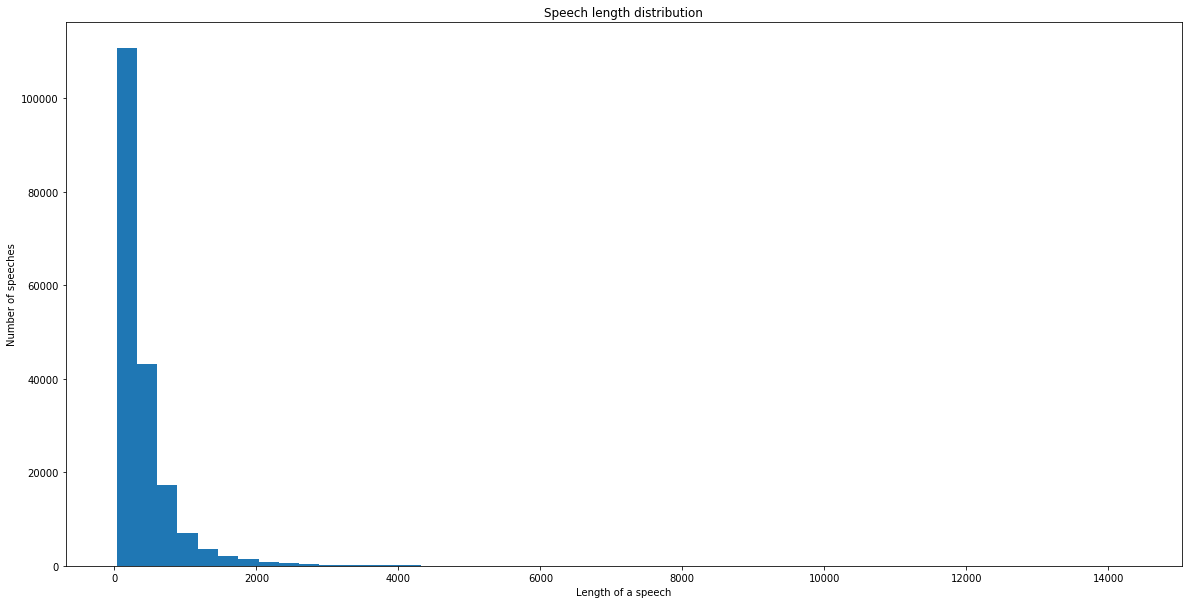

In [25]:
explore_data.plot_sample_length_distribution(train)

## CNN Models

### Pre-processing

In [26]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = 750

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [27]:
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train, val, test, **vec_params)
print("\nIt took {:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 175.0 seconds to tokenize the data


In [28]:
len(train), len(val), len(test)

(188148, 62716, 62716)

In [29]:
len(train_vec), len(val_vec), len(test_vec)

(188148, 62716, 62716)

In [30]:
max(map(max, train_vec)), max(map(max, val_vec)), max(map(max, test_vec))

(19999, 19999, 19999)

In [31]:
len(word_index)

476686

In [32]:
train_vec[0].shape

(750,)

In [33]:
train[0]

'Mr. Speaker. today I join my colleagues. our fellow Americans. and people around the world to offer our prayers to the families of those lost or injured in yesterdays unspeakable crimes. We stand here in solidarity with the President. who represents this Nation and its resolve to hunt down those responsible and bring them to justice. No one should doubt our unity and our commitment to rebuild in the wake of this deliberate tragedy. To the thousands of Americans who have lost loved ones or still wait in vigil for the missing. we offer prayers and hope for you who were devastated by yesterdays events. You have suffered an incredible personal tragedy and receive our sympathy for bearing the brunt of this assault on our Nation. To the people of New York. you demonstrated the finest heroism and humanity during the direst hour. Thousands of you risked your lives to help others as smoke. ash and debris rained on you. Thousands more of you streamed into blood donation centers to meet an incre

In [34]:
train_vec[0][-10:]

array([1609,    3, 2432, 1242,   11,    2, 1173,    8,  588,   61],
      dtype=int32)

In [35]:
# for word in train[0].split()[-10:]:
#     word = re.sub(r'[^\w\s]','',word)
#     print(word, word_index[word])

### Saving processed files

In [36]:
token_path = main_dir+'Classification/data/tokenized/gender'

In [37]:
np.save(os.path.join(token_path, 'train_vec'), train_vec)
np.save(os.path.join(token_path, 'val_vec'), val_vec)
np.save(os.path.join(token_path, 'test_vec'), test_vec)

In [38]:
pickle.dump(word_index, open(os.path.join(token_path, 'word_index.p'), 'wb'))

In [39]:
train_vec = np.load(os.path.join(token_path, 'train_vec.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec.npy'))

In [40]:
word_index = pickle.load(open(os.path.join(token_path, 'word_index.p'), 'rb'))

In [41]:
len(train_vec), len(val_vec), len(test_vec)

(188148, 62716, 62716)

## CNN model - Full Speech + Glove Embeddings

In [42]:
logs_base_dir = main_dir + 'Classification/logs/gender'

In [43]:
cnn_model_params = {
    'model': 'cnn',
    'word_index': word_index,
    'learning_rate': 0.001,
    'layers': 2,
    'epochs': 1000,
    'batch_size': 128,
    'filters': 64,
    'dropout_rate': 0.2,
    'embedding_dim': 200,
    'kernel_size': 5,
    'pool_size': 1,
    'max_num_words': 20000,
    'use_pretrained_embedding': True,
    'is_embedding_trainable': True,
    'glove_dir': main_dir + 'data'
}

In [44]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 20.0 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.1 seconds
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 188148 samples, validate on 62716 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1000
 - 1276s - loss: 0.6030 - acc: 0.6695 - val_loss: 0.5568 - val_acc: 0.7197
Epoch 2/1000
 - 1276s - loss: 0.5475 - acc: 0.7207 - val_loss: 0.5511 - val_acc: 0.7210
Epoch 3/1000
 - 1258s - loss: 0.5222 - acc: 0.7404 - val_loss: 0.5307 - val_acc: 0.7383
Epoch 4/1000
 - 1248s - loss: 0.5022 - acc: 0.7543 - val_loss: 0.5277 - val_acc: 0.7385
Epoch 5/1000
 - 1249s - loss: 0.4836 - acc: 0.7660 - val_loss: 0.5217 - val_acc: 0.7398
Epoch 6/1000
 - 1245s - loss: 0.4640 - a

### Clean up space/save outputs

In [45]:
probs_path = main_dir+'Classification/data/probs/gender/'

In [46]:
np.save(probs_path+'val_pred_probs_cnn', val_pred_probs, allow_pickle=True, fix_imports=True)

In [47]:
val_pred_probs = np.load(probs_path+'val_pred_probs_cnn.npy', allow_pickle=True, fix_imports=True)

## Model Evaluation

In [48]:
val_preds = val_pred_probs > 0.5
np.mean(val_preds.flatten()==val_target)

0.7364627846163658

In [49]:
val_preds.shape, len(val_target)

((62716, 1), 62716)

In [50]:
sum(val_preds)

array([31252])

Confusion matrix, without normalization
[[23147  8211]
 [ 8317 23041]]
             precision    recall  f1-score   support

       Male       0.74      0.74      0.74     31358
     Female       0.74      0.73      0.74     31358

avg / total       0.74      0.74      0.74     62716



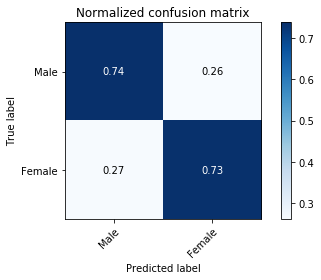

In [51]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

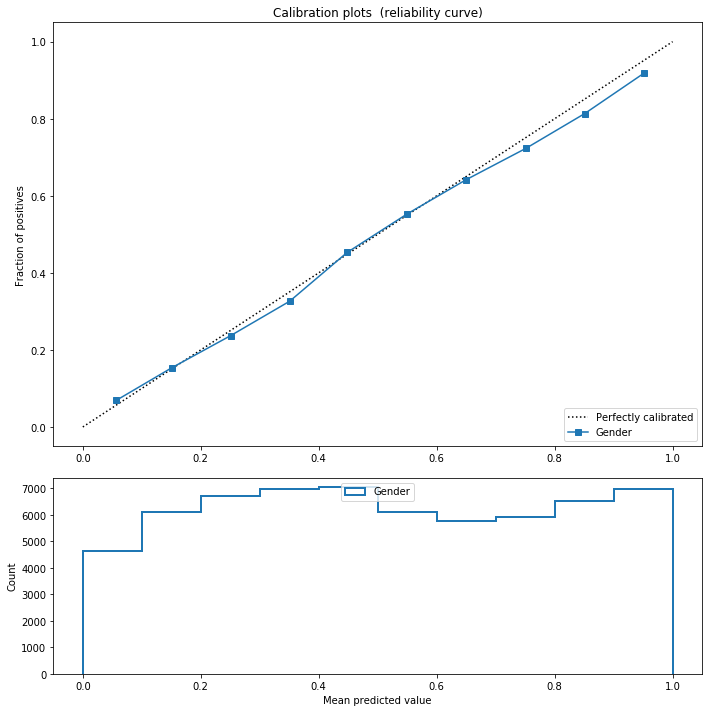

In [52]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [53]:
descr_df = pd.read_csv(main_dir+'data/QA/full_descr.txt', sep="|", index_col=0)
descr_df = descr_df.loc[np.asarray(val_ids, dtype=int)]
descr_df.shape

/home/yulia/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(62716, 16)

In [54]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base       0.5        0.17549  58.248453  0.621101   0.659624    392.229001


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.42,0.44,0.99,0.84,0.76,0.94
0.6,1.00,0.90,0.99,0.96,1.08,0.86
1.0,1.56,1.60,1.01,1.18,1.19,1.13


In [55]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
rise 	 2141.2
speaker rise 	 1593.9
rise today 	 1148.3
mr president 	 1057.1
women 	 997.2
colleagues to 	 947.0
our 	 813.5
speaker 	 732.1
their 	 729.3
support 	 726.9


bin,1,2,3
colleagues to,2103.0,1742.0,6106.0
mr president,15686.0,3761.0,5968.0
our,37875.0,24948.0,75860.0
rise,3549.0,2906.0,10746.0
rise today,1332.0,1146.0,4741.0
speaker,13538.0,10528.0,25861.0
speaker rise,1167.0,1203.0,5250.0
support,10129.0,6988.0,20906.0
their,25164.0,16014.0,47474.0
women,1667.0,1755.0,17854.0


In [56]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr_df)


True positive (Predicted prob: 0.97):

date             20010621
char_count           1632
word_count            272
speakerid     1.07119e+08
Party                   D
Congress              107
Chamber                 H
State                  CA
Ethnicity              ME
Age                    60
Age_lt_med              0
NonWhite                1
Female                  1
speaker         Ms. ESHOO
Full Name     ESHOO, ANNA
match               fuzzy
Name: 1070041709, dtype: object

 Mr. Speaker. I rise today to pay tribute to a distinguished American. and longtime constituent of Californias 14th Congressional DistrictAnn Dawson Torrey. who passed away on May 25. 2001. A lifelong Democrat and a staunch defender of womens rights. Ann Torrey was born in Hollywood. California on December 1. 1911. As a child she learned an early and important lessonthe power of civic activism. While still an infant. Anns mother pyshed her in a baby carriage during the historic marches for womens suffrage.

## CNN - chunking the data

### Prepare the data

In [57]:
chunk_len=50

In [58]:
reload(preprocess_data)
start_time = time.time()
train_chunk, train_ids_chunk, train_target_chunk = preprocess_data.split_speech_to_chunks(train, train_ids, train_target, max_len=chunk_len)
val_chunk, val_ids_chunk, val_target_chunk = preprocess_data.split_speech_to_chunks(val, val_ids, val_target, max_len=chunk_len)
test_chunk, test_ids_chunk, test_target_chunk = preprocess_data.split_speech_to_chunks(test, test_ids, test_target, max_len=chunk_len)
print("\nIt took {:.1f} seconds to create the dictionary".format(time.time()-start_time))

Original data has 188148 speeches
It was split into 1557233 chunks
Checks on ids and target 1557233 1557233
Original target mean 0.5
New target mean 0.5144747125189358
Original data has 62716 speeches
It was split into 521540 chunks
Checks on ids and target 521540 521540
Original target mean 0.5
New target mean 0.5181059937876289
Original data has 62716 speeches
It was split into 522421 chunks
Checks on ids and target 522421 522421
Original target mean 0.5
New target mean 0.5162503038736957

It took 14.7 seconds to create the dictionary


In [59]:
# Limit on the number of features. 
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
# MAX_SEQUENCE_LENGTH = 100
MAX_SEQUENCE_LENGTH = chunk_len

vec_params = {
    'num_words': TOP_K,
    'max_seq_length': MAX_SEQUENCE_LENGTH
}

In [60]:
start_time = time.time()
train_vec, val_vec, test_vec, word_index = preprocess_data.sequence_vectorize(train_chunk, val_chunk, test_chunk, **vec_params)
print("\nIt took {:.1f} seconds to tokenize the data".format(time.time()-start_time))


It took 223.9 seconds to tokenize the data


In [61]:
np.save(os.path.join(token_path, 'train_vec_chunk'), train_vec)
np.save(os.path.join(token_path, 'val_vec_chunk'), val_vec)
np.save(os.path.join(token_path, 'test_vec_chunk'), test_vec)

In [62]:
train_vec = np.load(os.path.join(token_path, 'train_vec_chunk.npy'))
val_vec = np.load(os.path.join(token_path, 'val_vec_chunk.npy'))
test_vec = np.load(os.path.join(token_path, 'test_vec_chunk.npy'))

In [63]:
train_vec.shape

(1557233, 50)

In [64]:
train_vec[0]

array([   28,    55,    69,    10,   324,    32,   109,    21,  1349,
         171,     5,    43,   335,     2,   162,     3,   550,    21,
        3351,     3,     2,   188,     4,    65,   497,    39,  2613,
           6,  6475, 10448,  1417,    13,   515,   124,     6,  5362,
          22,     2,    47,    36,  1249,    12,   189,     5,    73,
        1743,     3,  6983,   242,    65], dtype=int32)

In [65]:
type(train_vec)

numpy.ndarray

### Run the model

In [66]:
history_chunk, train_pred_probs_chunk, val_pred_probs_chunk = train_model.train_model(((train_vec, train_target_chunk), (val_vec, val_target_chunk)), logs_base_dir, **cnn_model_params)

Found 400000 word vectors.
It took 21.7 seconds
Preparing embedding matrix.
Embedding matrix has been built.
Its shape is (20000, 200).
It took 0.1 seconds
Train on 1557233 samples, validate on 521540 samples
Epoch 1/1000
 - 885s - loss: 0.6196 - acc: 0.6532 - val_loss: 0.6116 - val_acc: 0.6666
Epoch 2/1000
 - 893s - loss: 0.5985 - acc: 0.6757 - val_loss: 0.6055 - val_acc: 0.6725
Epoch 3/1000
 - 888s - loss: 0.5889 - acc: 0.6847 - val_loss: 0.6063 - val_acc: 0.6700
Epoch 4/1000
 - 892s - loss: 0.5792 - acc: 0.6928 - val_loss: 0.6044 - val_acc: 0.6746
Epoch 5/1000
 - 888s - loss: 0.5698 - acc: 0.7012 - val_loss: 0.6012 - val_acc: 0.6732
Epoch 6/1000
 - 887s - loss: 0.5600 - acc: 0.7090 - val_loss: 0.6029 - val_acc: 0.6736
Epoch 7/1000
 - 891s - loss: 0.5508 - acc: 0.7159 - val_loss: 0.6044 - val_acc: 0.6737
Validation accuracy: 0.6737220287322998, loss: 0.6044381352168


In [67]:
np.save(probs_path+'val_pred_probs_cnn_chunk', val_pred_probs_chunk, allow_pickle=True, fix_imports=True)

In [68]:
val_preds_chunk = val_pred_probs_chunk > 0.5
np.mean(val_preds_chunk.flatten()==val_target_chunk)

0.673722053917245

In [69]:
val_preds_chunk.shape

(521540, 1)

In [70]:
sum(val_preds_chunk)

array([264568])

In [71]:
pred_df = pd.DataFrame({'ids': val_ids_chunk, 'target': val_target_chunk, 'probs': val_pred_probs_chunk.flatten(), 'preds': val_preds_chunk.flatten()})
f = {'probs': [min, max, 'mean']}
pred_aggr_df = pred_df.groupby('ids').agg(f).reset_index()
pred_aggr_df.columns = ['ids', 'probs_min', 'probs_max', 'probs_mean']
pred_aggr_df = pred_aggr_df.merge(pred_df[['target', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df = pred_aggr_df.merge(pred_df[['preds', 'ids']].groupby('ids').mean().reset_index(), on='ids')
pred_aggr_df['preds_probs_mean'] = pred_aggr_df['probs_mean'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df['preds_mean'] = pred_aggr_df['preds'].apply(lambda x: 1 if x > 0.5 else 0)
pred_aggr_df.head()

,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1000000354,0.094680,0.624882,0.328274,0,0.166667,0,0
1,1000000454,0.263967,0.263967,0.263967,0,0.000000,0,0
2,1000000541,0.082468,0.525563,0.254600,0,0.037037,0,0
3,1000000727,0.126574,0.563237,0.311737,0,0.142857,0,0
4,1000000738,0.295573,0.522612,0.402547,0,0.142857,0,0


In [72]:
np.mean(pred_aggr_df.target == pred_aggr_df.preds_probs_mean), np.mean(pred_aggr_df.target == pred_aggr_df.preds_mean)

(0.7440047196887557, 0.7275495886217234)

In [73]:
original_df = pd.DataFrame({'target_orig': val_target, 'ids': val_ids})
original_df = original_df.merge(pred_aggr_df, on="ids")
original_df.head()

,target_orig,ids,probs_min,probs_max,probs_mean,target,preds,preds_probs_mean,preds_mean
0,1,1090179235,0.483563,0.729592,0.563669,1,0.750000,1,1
1,1,1090044795,0.478815,0.573090,0.539413,1,0.666667,1,1
2,1,1020046081,0.382570,0.926295,0.765542,1,0.800000,1,1
3,1,1090124860,0.435683,0.845979,0.592252,1,0.833333,1,1
4,1,1140096300,0.257996,0.604481,0.496121,1,0.800000,0,1


In [74]:
original_df.target_orig.sum(), original_df.target.sum()

(31358, 31358)

## Model evaluation

In [75]:
val_pred_aggr_chunk = original_df.preds_probs_mean
val_pred_probs_aggr_chunk = original_df.probs_mean
# val_aggr_target = pred_aggr_df.target
# val_aggr_ids = pred_aggr_df.ids

In [76]:
np.save(probs_path+'val_pred_probs_cnn_aggr_chunk', val_pred_probs_aggr_chunk, allow_pickle=True, fix_imports=True)

Confusion matrix, without normalization
[[23697  7661]
 [ 8394 22964]]
             precision    recall  f1-score   support

       Male       0.74      0.76      0.75     31358
     Female       0.75      0.73      0.74     31358

avg / total       0.74      0.74      0.74     62716



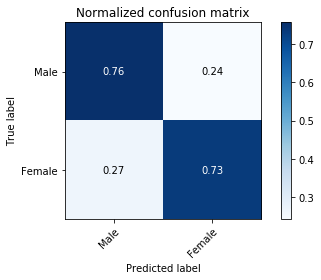

In [77]:
reload(explore_data)
# specify class names in 0 - 1 order
explore_data.plot_confusion_matrix(val_target, val_pred_aggr_chunk, classes, normalize=True)

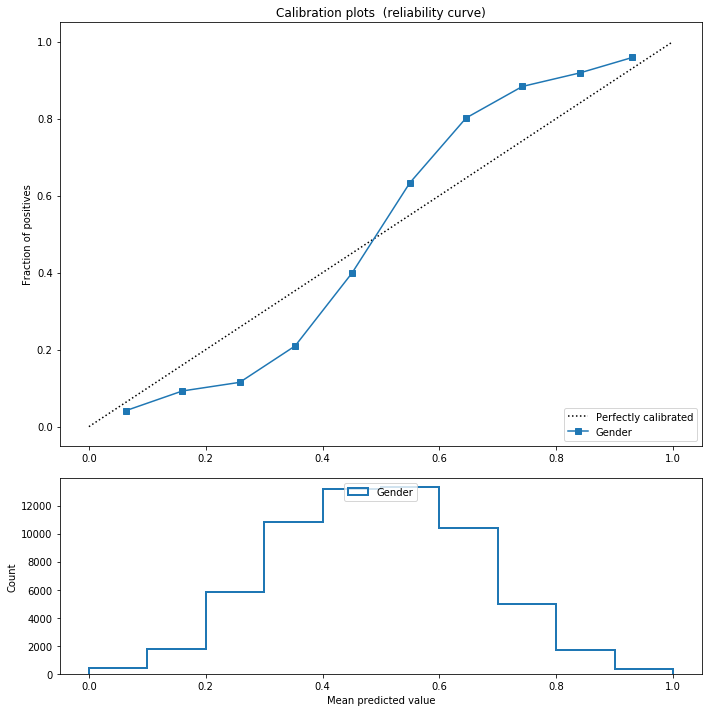

In [79]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs_aggr_chunk, 'Gender')

In [81]:
reload(explore_data)
# checking the ratios of demo variables in low-mid-high probability buckets
explore_data.check_bin_probs_distr(val_pred_probs_aggr_chunk, 
                                   val_ids, 
                                   descr_df)

Validation sample means:
      Gender_F  Ethinicity_NW     AvgAge   Party_D  Chamber_H  AvgWordCount
base       0.5        0.17549  58.248453  0.621101   0.659624    392.229001


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.33,0.37,0.99,0.82,0.70,0.81
0.6,1.03,0.89,0.99,0.96,1.07,1.12
1.0,1.68,1.85,1.03,1.25,1.22,1.01


In [82]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs_aggr_chunk, ngram_range=(1, 2))


Top 10 ngrams by differentiating score:
rise 	 1738.9
women 	 1488.0
speaker rise 	 1433.4
rise today 	 1234.9
mr president 	 1026.7
speaker 	 916.8
their 	 894.5
families 	 866.2
colleagues to 	 863.4
lives 	 825.6


bin,1,2,3
colleagues to,1308.0,4357.0,4286.0
families,934.0,6268.0,8209.0
lives,753.0,3896.0,4497.0
mr president,12711.0,9364.0,3340.0
rise,2289.0,7518.0,7394.0
rise today,696.0,2991.0,3532.0
speaker,8415.0,23899.0,17613.0
speaker rise,695.0,3116.0,3809.0
their,14490.0,42398.0,31764.0
women,659.0,4520.0,16097.0
